# 113th Congress Data

This notebook is meant to call, clean, and examine data from the 2012 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Retrieve data from Wikipedia

Wikipedia's current Cook PVI page contains a free and current (up to 2020 election results) version of the index, where free downloads from Cook's website are dated, containing 2018 results and 2016 PVI metrics

In [1]:
import requests
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#import and format url
url = "https://web.archive.org/web/20140814203944/https://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index"
page = pd.read_html(url)
dat = pd.concat(page,ignore_index=True)

In [3]:
#split data into state and district pvis
wiki_district = dat[6:442]
wiki_state = dat[447:]
#note that DC is accounted for in the district roster
wiki_district = wiki_district[wiki_district.State != "District of Columbia"].reset_index()

In [4]:
#cut NA columns
wiki_district = wiki_district.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
wiki_state = wiki_state.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

In [5]:
#check the various datasets
print(wiki_district.tail(1))
print(wiki_district.head(1))
print(wiki_state.tail(1))
print(wiki_state.head(1))

     index  District   PVI Party of Representative    State
434    441  At-large  R+22              Republican  Wyoming
   index District   PVI Party of Representative    State
0      6      1st  R+15              Republican  Alabama
    House balance   PVI Party in Senate Party of Governor    State
496            1R  R+22      Republican        Republican  Wyoming
    House balance   PVI Party in Senate Party of Governor    State
447        6R, 1D  R+14      Republican        Republican  Alabama


## Clean and Organize State Data

In [6]:
#call in a dictionary of state abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [7]:
state_113 = wiki_state
state_113["ST"] =  state_113["State"]
#abbreviate the ST coulmn
state_113 = state_113.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(state_113["ST"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [8]:
#split out pvi by party and weight
#first eliminate even values
state_113["PVI"] = state_113["PVI"].str.replace("EVEN","R+0")
state_113["pvi_party"] = state_113.PVI.str[0]
state_113['partisan_weight'] = state_113['PVI'].str.split('+').str[1]
#check results
print(state_113.head(n=1))
print(state_113["pvi_party"].unique())

    House balance   PVI Party in Senate Party of Governor    State  ST  \
447        6R, 1D  R+14      Republican        Republican  Alabama  AL   

    pvi_party partisan_weight  
447         R              14  
['R' 'D']


In [9]:
#add constants for later aggregation
state_113["year"] = 2012
state_113["congress"] = 113

In [10]:
#create a variable that is negative when the party is democratic
state_113["neg"] = state_113['pvi_party'].str.replace('D','-')
state_113["neg"] = state_113["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
state_113['partisan_weight'] = state_113["neg"] + state_113['partisan_weight']
#ensure values are integers
state_113['partisan_weight'] = state_113['partisan_weight'].astype(int)

In [11]:
state_113["metric"] = ((state_113['partisan_weight'] / 2) + 50) / 100
state_113.head(n=7)

,House balance,PVI,Party in Senate,Party of Governor,State,ST,pvi_party,partisan_weight,year,congress,neg,metric
447,"6R, 1D",R+14,Republican,Republican,Alabama,AL,R,14,2012,113,,0.570
448,1R,R+12,Both,Republican,Alaska,AK,R,12,2012,113,,0.560
449,"5D, 4R",R+7,Republican,Republican,Arizona,AZ,R,7,2012,113,,0.535
450,4R,R+14,Both,Democratic,Arkansas,AR,R,14,2012,113,,0.570
451,"38D, 15R",D+9,Democratic,Democratic,California,CA,D,-9,2012,113,-,0.455
452,"4R, 3D",D+1,Democratic,Democratic,Colorado,CO,D,-1,2012,113,-,0.495
453,5D,D+7,Democratic,Democratic,Connecticut,CT,D,-7,2012,113,-,0.465


In [12]:
state_113 = state_113[["year","ST","PVI","metric"]]
state_113.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_113.csv",index=False)

In [13]:
state_113.head(8)

,year,ST,PVI,metric
447,2012,AL,R+14,0.570
448,2012,AK,R+12,0.560
449,2012,AZ,R+7,0.535
450,2012,AR,R+14,0.570
451,2012,CA,D+9,0.455
452,2012,CO,D+1,0.495
453,2012,CT,D+7,0.465
454,2012,DE,D+8,0.460


## Clean and Organize the District Data

In [14]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [15]:
#load in and check the data
pvi_113 = wiki_district
print(pvi_113.head(n=1))
print(pvi_113.shape)

   index District   PVI Party of Representative    State
0      6      1st  R+15              Republican  Alabama
(435, 5)


In [16]:
#correct the column name for later use
pvi_113 = pvi_113.rename(columns={"Party of Representative": "Representative"})

In [17]:
#fix at large designation
pvi_113['District'] = pvi_113['District'].str.replace('at-large','AL')
pvi_113.head(n=8)

,index,District,PVI,Representative,State
0,6,1st,R+15,Republican,Alabama
1,7,2nd,R+17,Republican,Alabama
2,8,3rd,R+16,Republican,Alabama
3,9,4th,R+28,Republican,Alabama
4,10,5th,R+17,Republican,Alabama
5,11,6th,R+28,Republican,Alabama
6,12,7th,D+20,Democratic,Alabama
7,13,At-large,R+12,Republican,Alaska


In [18]:
#fix at large designation
pvi_113['District'] = pvi_113['District'].str.replace('At-large','AL')
pvi_113['District'] = pvi_113['District'].str.rstrip("st")
pvi_113['District'] = pvi_113['District'].str.rstrip("nd")
pvi_113['District'] = pvi_113['District'].str.rstrip("rd")
pvi_113['District'] = pvi_113['District'].str.rstrip("th")
pvi_113.head(n=8)

,index,District,PVI,Representative,State
0,6,1,R+15,Republican,Alabama
1,7,2,R+17,Republican,Alabama
2,8,3,R+16,Republican,Alabama
3,9,4,R+28,Republican,Alabama
4,10,5,R+17,Republican,Alabama
5,11,6,R+28,Republican,Alabama
6,12,7,D+20,Democratic,Alabama
7,13,AL,R+12,Republican,Alaska


In [19]:
#seperate state and district
pvi_113["num"] = pvi_113.District
pvi_113["ST"] =  pvi_113["State"]
pvi_113.head(n=1)

,index,District,PVI,Representative,State,num,ST
0,6,1,R+15,Republican,Alabama,1,Alabama


In [20]:
#abbreviate the ST coulmn
pvi_113 = pvi_113.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(pvi_113["ST"].unique())
print(pvi_113["num"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
['1' '2' '3' '4' '5' '6' '7' 'AL' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53']


In [21]:
#create the district code variable
pvi_113["ST#"] = pvi_113["ST"] + pvi_113["num"]
#create the "party of represenative" variable
pvi_113["seat"] = pvi_113.Representative.str[0]
#make a dummy
pvi_113["is_GOP"] = pvi_113["seat"].replace("R",1)
pvi_113["is_GOP"] = pvi_113["is_GOP"].replace("D",0)
#The seats of Charlie Dent and Pat Meehan in Pennsylvania went R -> D during this time frame
#covert to integer for later numeric analysis
pvi_113["is_GOP"] = pvi_113["is_GOP"].astype(int)
pvi_113.head(n=7)
print(pvi_113["is_GOP"].unique())

[1 0]


In [22]:
#possibly unneccessary
#pull out district lean
pvi_113["lean"] = pvi_113.PVI.str[0]
pvi_113["lean"].unique()

array(['R', 'D', 'E'], dtype=object)

In [23]:
#split out pvi by party and weight
#first eliminate even values
pvi_113["PVI"] = pvi_113["PVI"].str.replace("EVEN","R+0")
pvi_113["pvi_party"] = pvi_113.PVI.str[0]
pvi_113['partisan_weight'] = pvi_113['PVI'].str.split('+').str[1]
#check results
print(pvi_113.head(n=1))
print(pvi_113["pvi_party"].unique())

   index District   PVI Representative    State num  ST  ST# seat  is_GOP  \
0      6        1  R+15     Republican  Alabama   1  AL  AL1    R       1   

  lean pvi_party partisan_weight  
0    R         R              15  
['R' 'D']


In [24]:
#create a variable that is negative when the party is democratic
pvi_113["neg"] = pvi_113['pvi_party'].str.replace('D','-')
pvi_113["neg"] = pvi_113["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
pvi_113['partisan_weight'] = pvi_113["neg"] + pvi_113['partisan_weight']
#ensure values are integers
pvi_113['partisan_weight'] = pvi_113['partisan_weight'].astype(int)

In [25]:
pvi_113["metric"] = ((pvi_113['partisan_weight'] / 2) + 50) / 100
pvi_113.head(n=7)

,index,District,PVI,Representative,State,num,ST,ST#,seat,is_GOP,lean,pvi_party,partisan_weight,neg,metric
0,6,1,R+15,Republican,Alabama,1,AL,AL1,R,1,R,R,15,,0.575
1,7,2,R+17,Republican,Alabama,2,AL,AL2,R,1,R,R,17,,0.585
2,8,3,R+16,Republican,Alabama,3,AL,AL3,R,1,R,R,16,,0.580
3,9,4,R+28,Republican,Alabama,4,AL,AL4,R,1,R,R,28,,0.640
4,10,5,R+17,Republican,Alabama,5,AL,AL5,R,1,R,R,17,,0.585
5,11,6,R+28,Republican,Alabama,6,AL,AL6,R,1,R,R,28,,0.640
6,12,7,D+20,Democratic,Alabama,7,AL,AL7,D,0,D,D,-20,-,0.400


In [26]:
#add constants for later aggregation
pvi_113["year"] = 2012
pvi_113["congress"] = 113

## Export clean versions of the data

In [27]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_113 = pvi_113[["year","metric","is_GOP"]]
pure_113.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_113.csv",index=False)
#create a more detailed dataset for greater uses
data_113 = pvi_113[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_113.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_113.csv",index=False)

In [28]:
data_113.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
0,2012,113,AL,AL1,R,1,R+15,0.575
1,2012,113,AL,AL2,R,1,R+17,0.585
2,2012,113,AL,AL3,R,1,R+16,0.580
3,2012,113,AL,AL4,R,1,R+28,0.640
4,2012,113,AL,AL5,R,1,R+17,0.585
5,2012,113,AL,AL6,R,1,R+28,0.640
6,2012,113,AL,AL7,D,0,D+20,0.400
7,2012,113,AK,AKAL,R,1,R+12,0.560


## Conduct preliminary examinations of the data

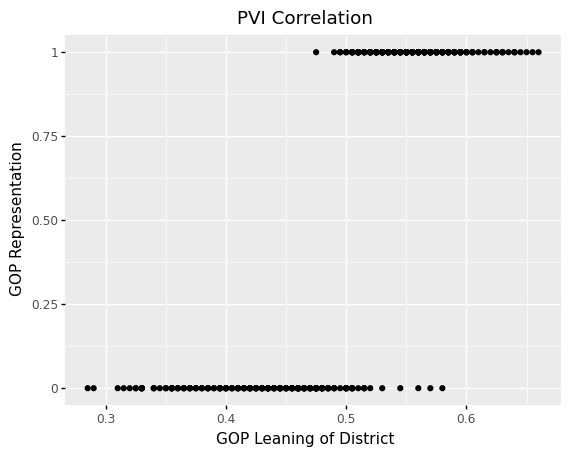

<ggplot: (8789611680832)>

In [29]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_113, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

From the 113th Congress, we can see that whil Generally PVI is effective, Democrats are winning a large number of Republican leaning districts

In [30]:
#group by metric and average GOP seats
bm_113 = pure_113.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_113 = bm_113.reset_index()

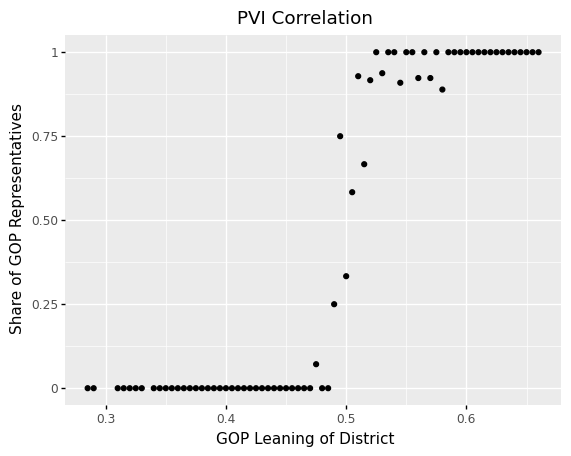

<ggplot: (8789611704239)>

In [31]:
#Plot averages
(p9.ggplot(data=bm_113, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

The regression line below and the data above informs of a slight Democratic advantage against PVI this cycle; remeber that the general Republican bias of the districts this cycle does not mean a Democratic advantage here.

In [32]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_113 = bm_113[bm_113["metric"] <= .55]
ld_113 = ld_113[ld_113["metric"] >= .45]

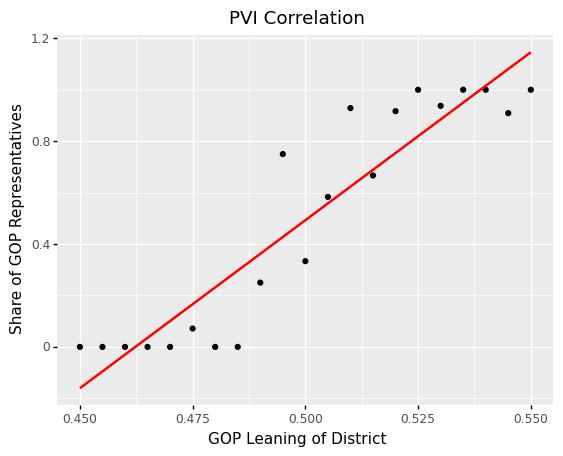

<ggplot: (8789612228021)>

In [33]:
#Plot averages
(p9.ggplot(data=ld_113, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))